In [1]:
import poloniex

In [2]:
import time

# poloniex APIの準備
polo = poloniex.Poloniex()

# 5分間隔（サンプリング間隔300秒）で100日分読み込む
chart_data = polo.returnChartData('BTC_ETH', period=300, start=time.time()-polo.DAY*100, end=time.time())

In [3]:
# pandasのインポート
import pandas as pd

# pandasにデータの取り込み
df = pd.DataFrame(chart_data)

In [4]:
# 短期線：窓幅1日（5分×12×24）
#data_s = pd.rolling_mean(df['close'], 12 * 24) 
data_s = df['close'].rolling(12 * 24).mean()

# 長期線：窓幅5日（5分×12×24×5）
#data_l = pd.rolling_mean(df['close'], 12 * 24 * 5)
data_l = df['close'].rolling(12 * 24 * 5).mean()

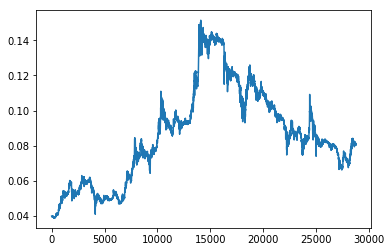

In [5]:
# matplotlibの読み込み（エラーが出た時はpip or pip3でインストール）
import matplotlib.pyplot as plt

# 一番簡単なプロット
plt.plot(df['close'])
plt.show()

In [6]:
# 描画を綺麗に表示する
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6

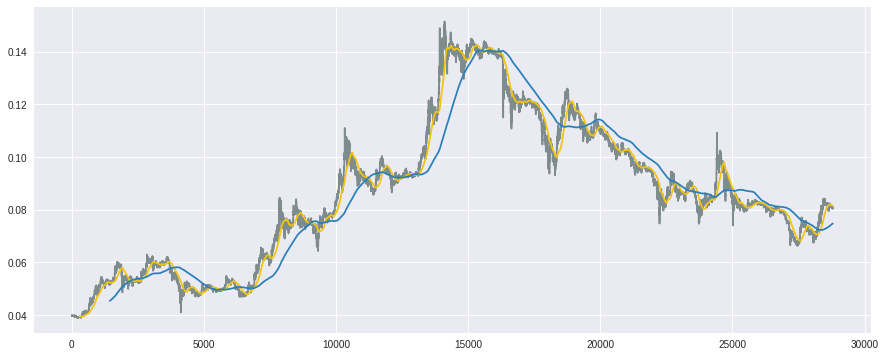

In [7]:
# 短期線と長期線もプロット
plt.plot(df['close'], color='#7f8c8d')
plt.plot(data_s, color='#f1c40f')  # 短期線
plt.plot(data_l, color='#2980b9')  # 長期線
plt.show()

In [8]:
# numpyの読み込み
import numpy as np

# API経由では文字列（String型）として受け取るため、float型に変換しておく
# また、Chainerではfloat32を推奨しているため、こちらに合わせておく
data = df['close'].astype(np.float32)

# データを入力変数xと出力変数tに切り分け
x, t = [], []
N = len(data)
M = 30 # 入力変数の数：直近30サンプルを使用
for n in range(M, N):
    # 入力変数と出力変数の切り分け
    _x = data[n-M: n] # 入力変数
    _t = data[n] # 出力変数
    # 計算用のリスト(x, t)に追加していく
    x.append(_x)
    t.append(_t)

In [9]:
# numpyの形式に変換する（何かと便利なため）
x = np.array(x)
t = np.array(t).reshape(len(t), 1)  # reshapeは後々のChainerでエラーが出ない対策

In [10]:
# 70%を訓練用、30%を検証用
N_train = int(N * 0.7)
x_train, x_test = x[:N_train], x[N_train:]
t_train, t_test = t[:N_train], t[N_train:]

In [11]:
# scikit-learnのlinear_modelを読み込み
from sklearn import linear_model

# 重回帰分析モデルの宣言
reg = linear_model.LinearRegression()

# 訓練データを使ったモデルの学習
reg.fit(x_train, t_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
# 訓練データ
reg.score(x_train, t_train)

# 検証データ
reg.score(x_test, t_test)

0.9983625881359216

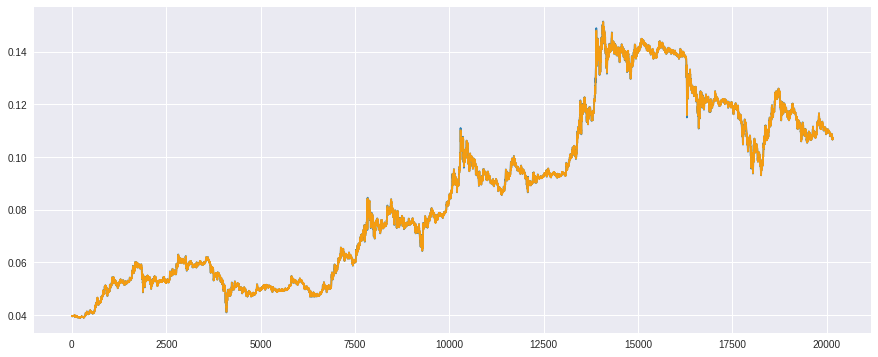

In [13]:
# 訓練データ
plt.plot(t_train, color='#2980b9')  # 実測値は青色
plt.plot(reg.predict(x_train), color='#f39c12')  # 予測値はオレンジ
plt.show()

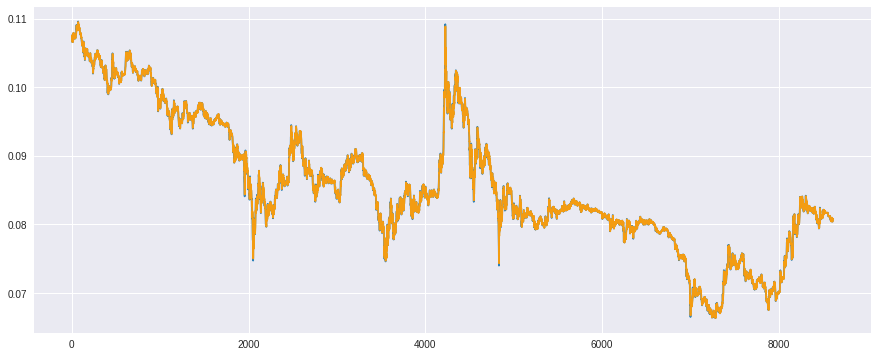

In [14]:
# 検証データ
plt.plot(t_test, color='#2980b9')  # 実測値は青色
plt.plot(reg.predict(x_test), color='#f39c12')  # 予測値はオレンジ
plt.show()

# ChaninerによるLSTM

In [15]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, datasets, optimizers
from chainer import report, training
from chainer.training import extensions

In [16]:
class LSTM(Chain):
    # モデルの構造を明記
    def __init__(self, n_units, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, n_units) # LSTMの層を追加
            self.l2 = L.Linear(None, n_output)

    # LSTM内で保持する値をリセット
    def reset_state(self):
        self.l1.reset_state()

    # 損失関数の計算
    def __call__(self, x, t, train=True):
        y = self.predict(x, train)
        loss = F.mean_squared_error(y, t)
        if train:
            report({'loss': loss}, self)
        return loss

    # 順伝播の計算
    def predict(self, x, train=False):
        # ドロップアウトの追加（訓練時のみ使うようにする）
        if train:
            h1 = F.dropout(self.l1(x), ratio=0.05)
        else:
            h1 = self.l1(x)
        h2 = self.l2(h1)
        return h2

In [17]:
class LSTMUpdater(training.StandardUpdater):
    def __init__(self, data_iter, optimizer, device=None):
        super(LSTMUpdater, self).__init__(data_iter, optimizer, device=None)
        self.device = device

    def update_core(self):
        data_iter = self.get_iterator("main")
        optimizer = self.get_optimizer("main")

        batch = data_iter.__next__()
        x_batch, y_batch = chainer.dataset.concat_examples(batch, self.device)

        # ↓ ここで reset_state() を実行できるようにしている
        optimizer.target.reset_state()

        # その他は時系列系の更新と同じ
        optimizer.target.cleargrads()
        loss = optimizer.target(x_batch, y_batch)
        loss.backward()
        # 時系列ではunchain_backward()によって計算効率が上がるそう
        loss.unchain_backward()
        optimizer.update()

In [18]:
# chainer用のデータセットでメモリに乗る程度であれば、list(zip(...))を推奨
# ↑ PFNの開発者推奨の方法
train = list(zip(x_train, t_train))
test  = list(zip(x_test,  t_test))

In [19]:
# 再現性確保
np.random.seed(1)

In [20]:
# モデルの宣言
model = LSTM(30, 1)

# optimizerの定義
optimizer = optimizers.Adam()  # 最適化アルゴリズムはAdamを使用
optimizer.setup(model)

# iteratorの定義
batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

# updaterの定義
updater = LSTMUpdater(train_iter, optimizer)

# trainerの定義
epoch = 30
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')
# trainerの拡張機能
trainer.extend(extensions.Evaluator(test_iter, model))    # 評価データで評価
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))    # 学習結果の途中を表示する
# １エポックごとに、trainデータに対するlossと、testデータに対するlossを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [21]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           4.82518e-05  0.115916              14.7079       
2           1.11899e-05  0.0738328             27.8458       
3           6.84314e-06  0.0320753             40.9479       
4           4.93807e-06  0.0100479             53.7899       
5           4.13792e-06  0.00444412            66.6064       
6           3.63686e-06  0.00530219            79.4369       
7           3.48954e-06  0.0036552             92.7863       
8           3.35063e-06  0.00269263            106.021       
9           3.2106e-06  0.00248772            119.493       
10          3.25171e-06  0.00293968            132.276       
11          3.14369e-06  0.00266697            145.024       
12          2.99648e-06  0.00257995            157.833       
13          3.1089e-06  0.00250825            170.841       
14          2.99884e-06  0.00265918            183.392       
15          2.99701e-06  0.00257563            195.901       
16          2

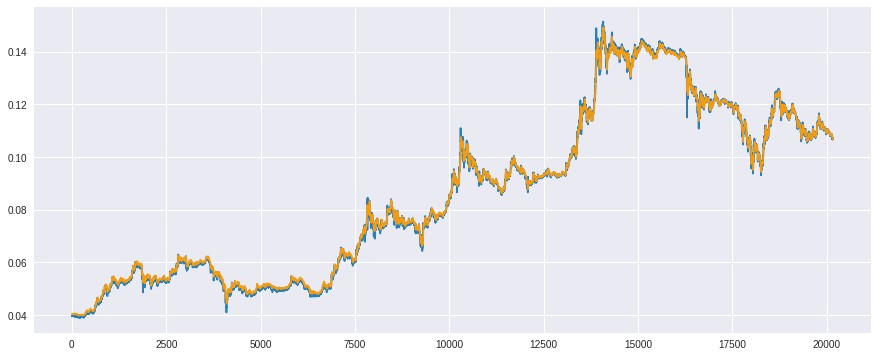

In [22]:
# 予測値の計算
model.reset_state()
y_train = model.predict(Variable(x_train)).data

# プロット
plt.plot(t_train, color='#2980b9') # 実測値は青色
plt.plot(y_train, color='#f39c12') # 予測値はオレンジ
plt.show()

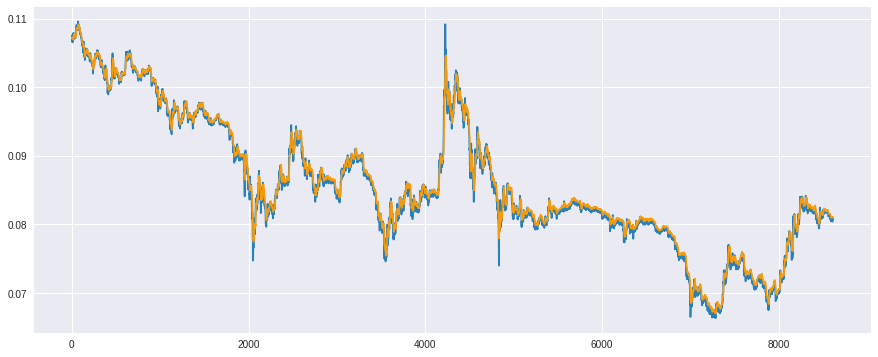

In [23]:
# 予測値の計算
model.reset_state()
y_test = model.predict(Variable(x_test)).data

# プロット
plt.plot(t_test, color='#2980b9')  # 実測値は青色
plt.plot(y_test, color='#f39c12')  # 予測値はオレンジ
plt.show()